<a href="https://colab.research.google.com/github/varundubey2804/Stress_Level_Prediction/blob/main/CNN_hyper_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
file_path = "/content/all-samples.csv"
df = pd.read_csv(file_path)

In [ ]:
df.shape

In [ ]:
df = df.dropna()

In [ ]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

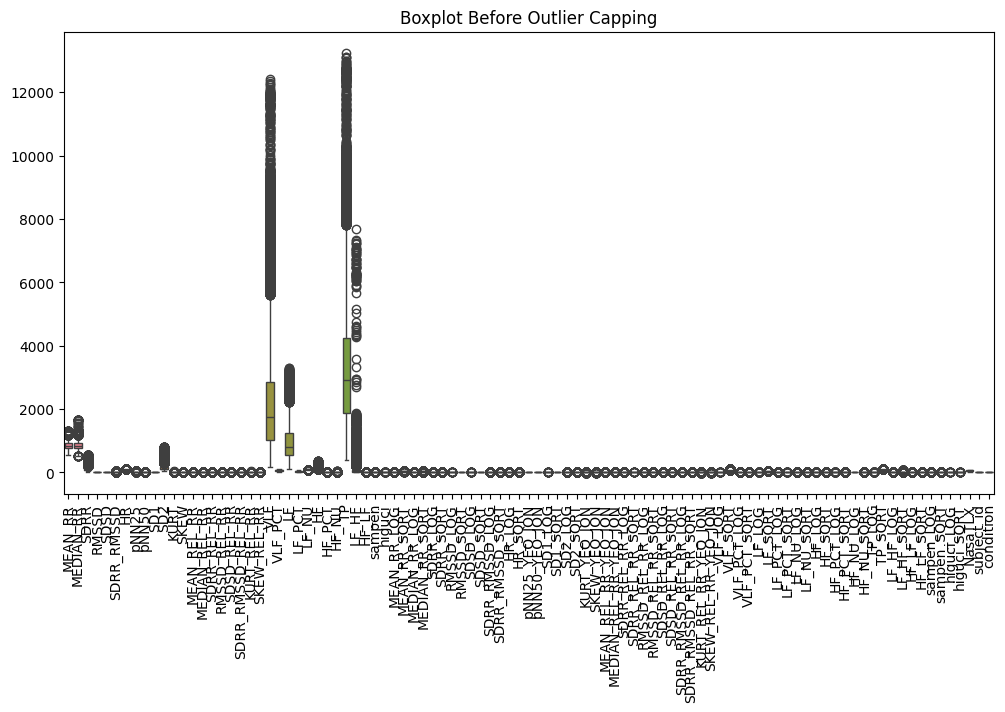

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot Before Outlier Capping")
plt.show()

In [ ]:
def cap_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply Capping
    data = data.apply(lambda x: np.where(x < lower_bound[x.name], lower_bound[x.name], x))
    data = data.apply(lambda x: np.where(x > upper_bound[x.name], upper_bound[x.name], x))

    return data

In [ ]:
df = cap_outliers_iqr(df)

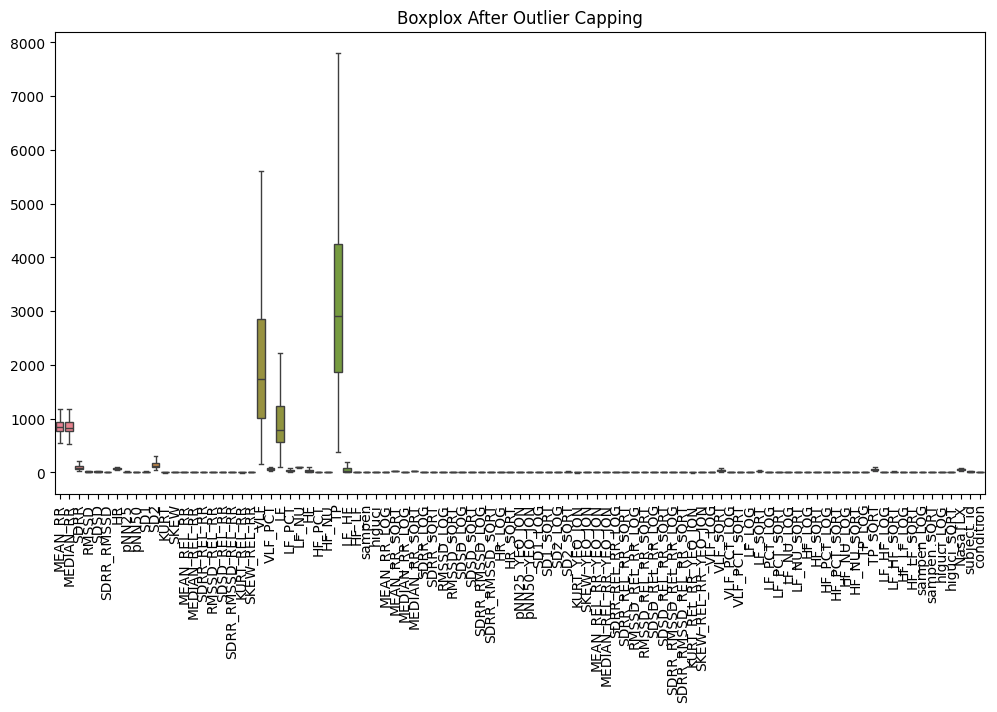

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplox After Outlier Capping")
plt.show()

In [ ]:
df.shape

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [ ]:

num_features_to_select = 10
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_new = selector.fit_transform(X, y)

In [ ]:
selected_features = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_features]
print(f"Selected Feature Names: {selected_feature_names.tolist()}")

Selected Feature Names: ['MEAN_RR', 'MEDIAN_RR', 'HR', 'MEAN_RR_LOG', 'MEAN_RR_SQRT', 'MEDIAN_RR_LOG', 'MEDIAN_RR_SQRT', 'HR_LOG', 'HR_SQRT', 'HF_PCT_SQRT']


In [ ]:
y = LabelEncoder().fit_transform(y)
y = to_categorical(y)

In [ ]:
df.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
pip install -q -U keras-tuner

In [ ]:
import keras_tuner as kt


In [ ]:
import keras
from keras import layers
import keras_tuner as kt

def model_builder(hp):
    model = keras.Sequential()


    model.add(layers.Input(shape=(10,1)))
    model.add(layers.Flatten())

    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu'))

    # Optionally, add a second hidden layer
    if hp.Boolean("second_layer"):
        second_layer_units = hp.Int('second_units', min_value=32, max_value=256, step=32)
        model.add(layers.Dense(units=second_layer_units, activation='relu'))

    # Output layer
    model.add(layers.Dense(y_train.shape[1], activation='softmax')) # assuming y_train is one-hot encoded

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy', # Use categorical_crossentropy for multi-class classification
                  metrics=['accuracy']) # Use 'accuracy' for multi-class classification

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 26 Complete [00h 00m 15s]
val_accuracy: 0.6144808530807495

Best val_accuracy So Far: 0.7139344215393066
Total elapsed time: 00h 13m 08s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
best_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8720 - loss: 0.3139 - val_accuracy: 0.8628 - val_loss: 0.3298
Epoch 2/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8737 - loss: 0.3124 - val_accuracy: 0.8530 - val_loss: 0.3423
Epoch 3/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8756 - loss: 0.2969 - val_accuracy: 0.8669 - val_loss: 0.3285
Epoch 4/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8720 - loss: 0.3036 - val_accuracy: 0.8601 - val_loss: 0.3286
Epoch 5/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8789 - loss: 0.2941 - val_accuracy: 0.8708 - val_loss: 0.2952
Epoch 6/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8791 - loss: 0.2969 - val_accuracy: 0.8609 - val_loss: 0.3385
Epoch 7/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8767 - loss: 0.3032 - val_accuracy: 0.8754 - val_loss: 0.3113
Epoch 8/50
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8792 - loss: 0.2935 - val_accuracy: 0.

In [ ]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 33


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert y_test to single-label format (multiclass)
y_test_single_label = np.argmax(y_test, axis=1)

# Now, use y_test_single_label in the classification_report
print(classification_report(y_test_single_label, y_pred))


246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2657
           1       0.88      0.94      0.91      2543
           2       0.95      0.92      0.93      2643

    accuracy                           0.92      7843
   macro avg       0.92      0.92      0.92      7843
weighted avg       0.92      0.92      0.92      7843



In [ ]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9213 - loss: 0.2175
Test Accuracy: 92.11%
